In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.utils import resample
from sklearn import linear_model, tree, svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, confusion_matrix, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from prettytable import PrettyTable
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
%matplotlib inline

In [54]:
df = pd.read_csv('aggregate.csv', encoding = "ISO-8859-1")

In [55]:
df.tail(1)

,business_id,address,name,yelp_star,mean_star,review_count,demerit,grade,keyword_count,inspection_fail_count,inspection_fail_indicator,one_star_count,prop_one_star
9639,zzzaIBwimxVej4tY6qFOUQ,6728 W Cheyenne Ave,Guthrie's,3.5,3.432432,37,"[8, 2, 3]","['A', 'A', 'A']","{'sick': 1, 'dirty': 1, 'disgusting': 1, 'vomi...",0,0,4,0.108108


In [56]:
# create total keyword count column and split keyword_count into many columns
for i in range(len(df)):
    keywords = ast.literal_eval(df.at[i, 'keyword_count'])
    df.at[i, "keyword_total"] = sum(keywords.values())
    for word in keywords:
        df.at[i, word] = keywords[word]

In [57]:
df.tail(1)

,business_id,address,name,yelp_star,mean_star,review_count,demerit,grade,keyword_count,inspection_fail_count,...,contaminate,bacteria,salmonella,e coli,infest,retch,gag,stench,e-coli,tainted
9639,zzzaIBwimxVej4tY6qFOUQ,6728 W Cheyenne Ave,Guthrie's,3.5,3.432432,37,"[8, 2, 3]","['A', 'A', 'A']","{'sick': 1, 'dirty': 1, 'disgusting': 1, 'vomi...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
#scatterMatrix = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(18, 18), diagonal='kde')

In [59]:
# Prep dataframes for models
X = df.drop(['business_id', 'address', 'name', 'demerit', 'grade', 'inspection_fail_count', 'inspection_fail_indicator', 'keyword_count'], axis=1)
Y_categorize = df[['inspection_fail_indicator']]
Y_regression = df[['inspection_fail_count']]
X_lasso = df[['review_count', 'one_star_count', 'dirty']]
X.tail(1)

,yelp_star,mean_star,review_count,one_star_count,prop_one_star,keyword_total,sick,dirty,disgusting,vomit,...,contaminate,bacteria,salmonella,e coli,infest,retch,gag,stench,e-coli,tainted
9639,3.5,3.432432,37,4,0.108108,5.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


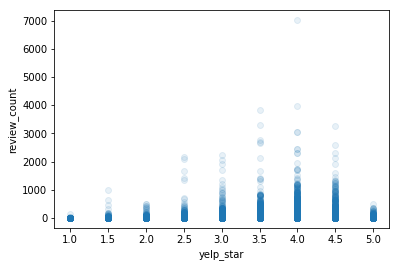

In [100]:
# Plot some variables against one another
plt.scatter(df.yelp_star, df.review_count, alpha = 0.1)
plt.ylabel("review_count")
plt.xlabel("yelp_star")
plt.show()

# X.groupby('yelp_star').count()["review_count"]

In [98]:
df.corr()

,yelp_star,mean_star,review_count,inspection_fail_count,inspection_fail_indicator,one_star_count,prop_one_star,keyword_total,sick,dirty,...,contaminate,bacteria,salmonella,e coli,infest,retch,gag,stench,e-coli,tainted
yelp_star,1.000000,0.987644,0.056935,-0.057948,0.001135,-0.177226,-0.862140,-0.065720,-0.027116,-0.071395,...,-0.017378,-0.019669,0.004359,-0.003644,-0.047584,0.027006,0.010972,-0.031048,0.004705,0.001037
mean_star,0.987644,1.000000,0.054959,-0.058359,0.000113,-0.180594,-0.874760,-0.069431,-0.030550,-0.074778,...,-0.017704,-0.019887,0.001798,-0.002811,-0.048071,0.025095,0.011993,-0.033420,0.003221,-0.000664
review_count,0.056935,0.054959,1.000000,0.127381,0.056918,0.705520,-0.117472,0.748436,0.799252,0.590361,...,0.355872,0.243706,0.124986,0.021169,0.326036,0.586329,0.158779,0.374330,0.066785,0.332503
inspection_fail_count,-0.057948,-0.058359,0.127381,1.000000,0.224136,0.139637,0.000104,0.117128,0.122559,0.084332,...,0.033861,0.045134,0.000414,0.002239,0.048003,0.106035,0.055574,0.047071,0.011227,0.070156
inspection_fail_indicator,0.001135,0.000113,0.056918,0.224136,1.000000,0.043688,-0.022723,0.047617,0.045743,0.038983,...,0.005783,0.017980,0.008842,-0.013812,0.016754,0.026868,0.022557,0.019885,0.003178,0.020863
one_star_count,-0.177226,-0.180594,0.705520,0.139637,0.043688,1.000000,0.123241,0.851386,0.709797,0.769255,...,0.318842,0.338318,0.045088,0.016819,0.517891,0.489108,0.139705,0.524349,0.032094,0.296734
prop_one_star,-0.862140,-0.874760,-0.117472,0.000104,-0.022723,0.123241,1.000000,-0.001205,-0.034821,0.018902,...,-0.009675,-0.000530,-0.011983,-0.005218,0.018674,-0.056260,-0.029130,-0.001376,-0.008962,-0.027552
keyword_total,-0.065720,-0.069431,0.748436,0.117128,0.047617,0.851386,-0.001205,1.000000,0.784368,0.925821,...,0.395479,0.351094,0.086903,0.014959,0.609481,0.592228,0.169019,0.646678,0.030467,0.317874
sick,-0.027116,-0.030550,0.799252,0.122559,0.045743,0.709797,-0.034821,0.784368,1.000000,0.576582,...,0.394478,0.257452,0.127713,0.028175,0.291128,0.586075,0.131365,0.335311,0.049848,0.281161
dirty,-0.071395,-0.074778,0.590361,0.084332,0.038983,0.769255,0.018902,0.925821,0.576582,1.000000,...,0.305994,0.312282,0.040739,0.007196,0.625314,0.448170,0.138195,0.670245,0.005507,0.256089


In [8]:
# Up-sample Minority Class for Y_categorize
print(df.inspection_fail_indicator.value_counts())
print(7987/9640)

1    7987
0    1653
Name: inspection_fail_indicator, dtype: int64
0.8285269709543569


In [9]:
df_majority = df[df.inspection_fail_indicator==1]
df_minority = df[df.inspection_fail_indicator==0]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,      # sample with replacement
                                 n_samples=7987,    # to match majority class
                                 random_state=23)   # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.inspection_fail_indicator.value_counts()

1    7987
0    7987
Name: inspection_fail_indicator, dtype: int64

In [10]:
# Prep up-sampled dataframes for models
Xup = df.drop(['business_id', 'address', 'name', 'demerit', 'grade', 'inspection_fail_count', 'inspection_fail_indicator', 'keyword_count'], axis=1)
Yup_categorize = df[['inspection_fail_indicator']]
Yup_regression = df[['inspection_fail_count']]

In [11]:
# Normalize the dataset
X = (X - X.mean()) / X.std()
Xup = (Xup - Xup.mean()) / Xup.std()

In [12]:
####################
##   Regression   ##
####################

In [13]:
# Simple Linear Regression
lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, Y_regression, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.03 (+/- 0.05)


/Users/philip/homebrew/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [16]:
scores = cross_validate(lm, X, Y_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print(scores["test_score"])
print("Simple Linear Regression Test MSE:", scores["test_score"].mean())

[-841.52277072 -651.84139568 -556.40532041 -717.89101819 -638.05139889
 -705.83798936 -629.62850308 -545.67935926 -645.3786017  -477.02011181]
Simple Linear Regression Test MSE: -640.9256469104048


In [17]:
# Lasso
lasso = linear_model.Lasso()
scores = cross_validate(lm, X, Y_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print("Lasso Test MSE:", scores["test_score"].mean())

Lasso Test MSE: -640.9256477900678


In [47]:
# K Nearest Neighbor Regression
Klist = []
for K in range(1,51):
    knn = KNeighborsRegressor(n_neighbors=K)
    Kscores = cross_val_score(knn, X, np.ravel(Y_regression), cv=10)
    Klist.append(Kscores.mean())
    if (K%10 == 0): 
        print(K)

10
20
30
40
50


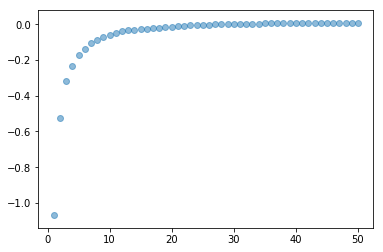

In [48]:
plt.scatter(range(1,51), Klist, alpha = 0.5)

In [20]:
knn = KNeighborsRegressor(n_neighbors=5)
scores = cross_validate(knn, X, Y_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print("KNN K=5 Test MSE:", scores["test_score"].mean())

KNN K=5 Test MSE: -771.5726182572614


In [21]:
# Decision Trees

In [22]:
dtree = tree.DecisionTreeRegressor()
scores = cross_val_score(dtree, X, Y_regression, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.73 (+/- 0.28)


In [23]:
scores = cross_validate(dtree, X, Y_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print("Decision Tree Test MSE:", scores["test_score"].mean())

Decision Tree Test MSE: -1133.8951056219848


In [24]:
# Random Forest
forest = RandomForestClassifier(min_samples_leaf=10, n_jobs=4)
scores = cross_val_score(forest, X, np.ravel(Y_regression), cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/Users/philip/homebrew/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.16 (+/- 0.01)


In [25]:
scores = cross_validate(forest, X, np.ravel(Y_regression), cv=10, scoring="neg_mean_squared_error")
print("Random Forest Test MSE:", scores["test_score"].mean())

/Users/philip/homebrew/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Random Forest Test MSE: -818.9614717666561


In [26]:
# SVM

In [27]:
svr = svm.SVR()
scores = cross_val_score(svr, X, np.ravel(Y_regression), cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.10 (+/- 0.01)


In [28]:
scores = cross_validate(svr, X, np.ravel(Y_regression), cv=10, scoring="neg_mean_squared_error")
print("Random Forest Test MSE:", scores["test_score"].mean())

Random Forest Test MSE: -730.2457373093201


In [29]:
####################
##   Regression   ##
##   Up Sampled   ##
####################

In [30]:
# Simple Linear Regression
lm = linear_model.LinearRegression()
scores = cross_val_score(lm, Xup, Yup_regression, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.03 (+/- 0.05)


In [31]:
scores = cross_validate(lm, Xup, Yup_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print("Simple Linear Regression Test MSE:", scores["test_score"].mean())

Simple Linear Regression Test MSE: -640.9256460397999


In [34]:
# Lasso
lasso = linear_model.Lasso()
scores = cross_validate(lm, Xup, Yup_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print("Lasso Test MSE:", scores["test_score"].mean())

Lasso Test MSE: -640.9256472098258


In [35]:
# K Nearest Neighbor Regression
Klist = []
for K in range(1,51):
    knn = KNeighborsRegressor(n_neighbors=K)
    Kscores = cross_val_score(knn, Xup, np.ravel(Yup_regression), cv=10)
    Klist.append(Kscores.mean())
    if (K%10 == 0): 
        print(K)

10
20
30
40
50


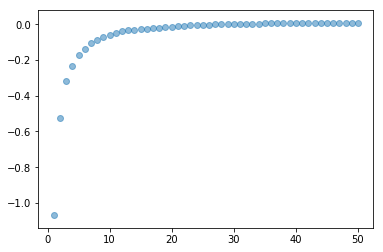

In [36]:
plt.scatter(range(1,51), Klist, alpha = 0.5)

In [37]:
knn = KNeighborsRegressor(n_neighbors=7)
scores = cross_validate(knn, Xup, Yup_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print("KNN K=7 Test MSE:", scores["test_score"].mean())

KNN K=7 Test MSE: -730.6193136590737


In [38]:
# Decision Trees

In [39]:
dtree = tree.DecisionTreeRegressor()
scores = cross_val_score(dtree, Xup, Yup_regression, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.73 (+/- 0.23)


In [40]:
# Random Forest
forest = RandomForestClassifier(min_samples_leaf=10, n_jobs=4)
scores = cross_val_score(forest, Xup, np.ravel(Yup_regression), cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/Users/philip/homebrew/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.16 (+/- 0.02)


In [41]:
scores = cross_validate(forest, Xup, np.ravel(Yup_regression), cv=10, scoring="neg_mean_squared_error")
print("Random Forest Test MSE:", scores["test_score"].mean())

/Users/philip/homebrew/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Random Forest Test MSE: -814.0794442122499


In [42]:
# SVM
svr = svm.SVR()
scores = cross_val_score(svr, Xup, np.ravel(Yup_regression), cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.10 (+/- 0.01)


In [43]:
scores = cross_validate(svr, Xup, np.ravel(Yup_regression), cv=10, scoring="neg_mean_squared_error")
print("SVM Test MSE:", scores["test_score"].mean())

SVM Test MSE: -730.2457373093201


In [18]:
########################
##   Classification   ##
########################

In [49]:
# K Nearest Neighbor

Klist = []
for K in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=K)
    Kscores = cross_val_score(knn, X, np.ravel(Y_categorize), cv=10)
    Klist.append(Kscores.mean())
    if (K%10 == 0): 
        print(K)

10
20
30
40
50


In [50]:
Kliststist

[0.7160770424302597,
 0.60269081485253,
 0.7662863691185698,
 0.7207446633517458,
 0.7890009997093456,
 0.7699140659410775,
 0.8178414526257457,
 0.8079863520999131,
 0.8226125936631702,
 0.8185665180665334,
 0.8270737165252587,
 0.825310122434981,
 0.8279042381411742,
 0.8263480054337359,
 0.8275935725290704,
 0.8271785270496513,
 0.8281122449514946,
 0.8275936800258993,
 0.8284235559910795,
 0.8282160871114115,
 0.8284235559910795,
 0.8284235559910795,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340848,
 0.8285271829340

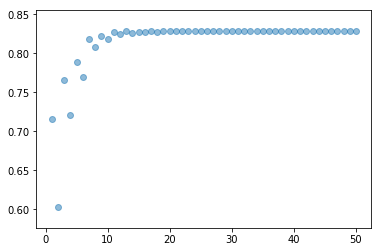

In [45]:
plt.scatter(range(1,51), Klist, alpha = 0.5)

In [46]:
# KNN K = 7
knn = KNeighborsClassifier(n_neighbors=7)
scores = cross_val_score(knn, X, np.ravel(Y_categorize), cv=10)
print("KNN K=7\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(knn, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

KNN K=7
Accuracy: 0.82 (+/- 0.01)
Accuracy: 0.8178414526257457 
Precision: 0.8296491427717667 
Recall: 0.9817196307414344 
f1: 0.8992907952987569


In [24]:
# logistic regression
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, np.ravel(Y_categorize), cv=10)
print("Logistic Regression\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(logreg, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Logistic Regression
Accuracy: 0.83 (+/- 0.00)
Accuracy: 0.828215979391 
Precision: 0.828473753881 
Recall: 0.999624373826 
f1: 0.906037223817


In [25]:
# LDA
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, X, np.ravel(Y_categorize), cv=10)
print("LDA\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(lda, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables ar

LDA
Accuracy: 0.83 (+/- 0.00)


/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy: 0.828215979391 
Precision: 0.828473753881 
Recall: 0.999624373826 
f1: 0.906037223817


/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [26]:
# QDA
qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(qda, X, np.ravel(Y_categorize), cv=10)
print("QDA\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(qda, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear


QDA
Accuracy: 0.24 (+/- 0.02)


/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear


Accuracy: 0.243253758108 
Precision: 0.886389630652 
Recall: 0.0994074673542 
f1: 0.178359332092


/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [27]:
# Decision Trees
dtree = tree.DecisionTreeClassifier()
scores = cross_val_score(dtree, X, Y_categorize, cv=10)
print("Decision Tree\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(dtree, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Decision Tree
Accuracy: 0.74 (+/- 0.02)
Accuracy: 0.734858687214 
Precision: 0.829184656068 
Recall: 0.856392702658 
f1: 0.842528760247


In [16]:
# Random Forest
forest = RandomForestClassifier(min_samples_leaf=10, n_jobs=4, class_weight="balanced")
scores = cross_val_score(forest, X, np.ravel(Y_categorize), cv=10)
print("Random Forest\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(forest, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Random Forest
Accuracy: 0.58 (+/- 0.04)
Accuracy: 0.5845316775071023 
Precision: 0.833645462238931 
Recall: 0.6227529085542391 
f1: 0.7122758479020495


In [29]:
# SVM
svmModel = svm.SVC()
scores = cross_val_score(svmModel, X, np.ravel(Y_categorize), cv=10)
print("SVM\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(svmModel, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

SVM
Accuracy: 0.83 (+/- 0.00)
Accuracy: 0.828527182934 
Precision: 0.828527182934 
Recall: 1.0 
f1: 0.906223490207


In [51]:
########################
##   Classification   ##
##   Up Sampled       ##
########################

In [62]:
# K Nearest Neighbor

Klist = []
for K in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=K)
    Kscores = cross_val_score(knn, Xup, np.ravel(Yup_categorize), cv=10)
    Klist.append(Kscores.mean())
    if (K%10 == 0): 
        print(K)

10
20
30
40
50


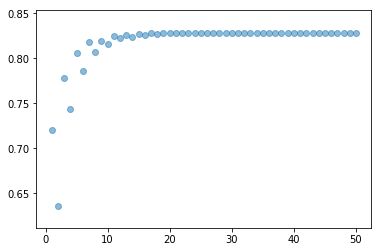

In [63]:
plt.scatter(range(1,51), Klist, alpha = 0.5)

In [52]:
# KNN K = 7
knn = KNeighborsClassifier(n_neighbors=7)
scores = cross_val_score(knn, Xup, np.ravel(Yup_categorize), cv=10)
print("KNN K=7\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(knn, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

KNN K=7
Accuracy: 0.82 (+/- 0.01)
Accuracy: 0.8178414526257457 
Precision: 0.8296491427717667 
Recall: 0.9817196307414344 
f1: 0.8992907952987569


In [65]:
# logistic regression
logreg = LogisticRegression()
scores = cross_val_score(logreg, Xup, np.ravel(Yup_categorize), cv=10)
print("Logistic Regression\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(logreg, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Logistic Regression
Accuracy: 0.83 (+/- 0.00)
Accuracy: 0.8282158718944999 
Precision: 0.8284737875894574 
Recall: 0.999624373825678 
f1: 0.9060371472696435


In [66]:
# LDA
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, Xup, np.ravel(Yup_categorize), cv=10)
print("LDA\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(lda, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

LDA
Accuracy: 0.83 (+/- 0.00)


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

Accuracy: 0.8282159793913285 
Precision: 0.8284737538813436 
Recall: 0.999624373825678 
f1: 0.9060372238170613


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [67]:
# QDA
qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(qda, Xup, np.ravel(Yup_categorize), cv=10)
print("QDA\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(qda, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminan

QDA
Accuracy: 0.24 (+/- 0.03)


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminan

Accuracy: 0.23930797549000857 
Precision: 0.8949612149814362 
Recall: 0.09314650832337415 
f1: 0.16770297461298356


In [68]:
# Decision Trees
dtree = tree.DecisionTreeClassifier()
scores = cross_val_score(dtree, Xup, Yup_categorize, cv=10)
print("Decision Tree\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(dtree, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Decision Tree
Accuracy: 0.73 (+/- 0.02)
Accuracy: 0.734236066697507 
Precision: 0.8295688909243346 
Recall: 0.8548912958240406 
f1: 0.8420001458024011


In [69]:
# Random Forest
forest = RandomForestClassifier(min_samples_leaf=10, n_jobs=4, class_weight="balanced")
scores = cross_val_score(forest, Xup, np.ravel(Yup_categorize), cv=10)
print("Random Forest\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(forest, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Random Forest
Accuracy: 0.58 (+/- 0.04)
Accuracy: 0.5805923473777772 
Precision: 0.8319856656024193 
Recall: 0.6186208637990471 
f1: 0.7091838642775147


In [17]:
# SVM
svmModel = svm.SVC()
scores = cross_val_score(svmModel, Xup, np.ravel(Yup_categorize), cv=10)
print("SVM\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(svmModel, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

SVM
Accuracy: 0.83 (+/- 0.00)
Accuracy: 0.828215871894 
Precision: 0.828473824541 
Recall: 0.999624373826 
f1: 0.906037217758


In [18]:
X.sum()

yelp_star          35147.000000
mean_star          35146.781144
review_count      801880.000000
one_star_count    104503.000000
prop_one_star       1849.035010
keyword_total      37420.000000
sick                5405.000000
dirty              10613.000000
disgusting          4902.000000
vomit                674.000000
threw up             318.000000
food poison         1327.000000
diarrhea             299.000000
filthy              1593.000000
gross               5511.000000
throw up             279.000000
throwing up          257.000000
indigestion           72.000000
nausea               254.000000
nauseous             219.000000
upset stomach        146.000000
the runs              99.000000
 bug                 694.000000
 rat                 230.000000
mice                 829.000000
mouse                252.000000
expired              552.000000
listeria               3.000000
contaminate          151.000000
bacteria             180.000000
salmonella            80.000000
e coli  

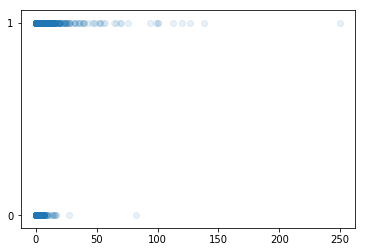

In [34]:
plt.scatter(X.dirty, Y_categorize, alpha=0.1)

In [ ]:
# Classification subset

In [14]:
# Lasso selected variables after normalizing
X_subset = X[["yelp_star", "review_count", "one_star_count", "food poison", "throw up", "nauseous", "retch", " gag "]]


In [46]:
# K Nearest Neighbor

Klist = []
for K in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=K)
    Kscores = cross_val_score(knn, X_subset, np.ravel(Y_categorize), cv=10)
    Klist.append(Kscores.mean())
    if (K%10 == 0): 
        print(K)

10
20


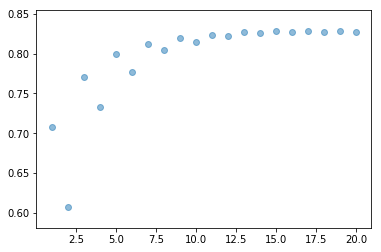

In [47]:
plt.scatter(range(1,21), Klist, alpha = 0.5)

In [76]:
# KNN K = 7
knn = KNeighborsClassifier(n_neighbors=7)
scores = cross_val_score(knn, X_subset, np.ravel(Y_categorize), cv=10)
print("KNN K=7\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(knn, X_subset, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

KNN K=7
Accuracy: 0.81 (+/- 0.02)
Accuracy: 0.812346106122 
Precision: 0.828750381112 
Recall: 0.974960712168 
f1: 0.89588667951


In [49]:
# logistic regression
logreg = LogisticRegression()
scores = cross_val_score(logreg, X_subset, np.ravel(Y_categorize), cv=10)
print("Logistic Regression\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(logreg, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Logistic Regression
Accuracy: 0.83 (+/- 0.00)
Accuracy: 0.828215871894 
Precision: 0.828473787589 
Recall: 0.999624373826 
f1: 0.90603714727


In [50]:
# LDA
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, X_subset, np.ravel(Y_categorize), cv=10)
print("LDA\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(lda, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

LDA
Accuracy: 0.83 (+/- 0.00)


/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy: 0.828215979391 
Precision: 0.828473753881 
Recall: 0.999624373826 
f1: 0.906037223817


/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [51]:
# QDA
qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(qda, X_subset, np.ravel(Y_categorize), cv=10)
print("QDA\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(qda, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

QDA
Accuracy: 0.28 (+/- 0.03)


/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear


Accuracy: 0.264198124001 
Precision: 0.882307899897 
Recall: 0.129324562972 
f1: 0.224197266911


In [52]:
# Decision Trees
dtree = tree.DecisionTreeClassifier()
scores = cross_val_score(dtree, X_subset, Y_categorize, cv=10)
print("Decision Tree\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(dtree, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Decision Tree
Accuracy: 0.75 (+/- 0.02)
Accuracy: 0.731953046591 
Precision: 0.828548494314 
Recall: 0.853012694439 
f1: 0.840558030976


In [53]:
# Random Forest
forest = RandomForestClassifier(min_samples_leaf=10, n_jobs=4, class_weight="balanced")
scores = cross_val_score(forest, X_subset, np.ravel(Y_categorize), cv=10)
print("Random Forest\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(forest, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Random Forest
Accuracy: 0.53 (+/- 0.06)
Accuracy: 0.594398507243 
Precision: 0.83532577067 
Recall: 0.635908293889 
f1: 0.721800121893


In [54]:
# SVM
svmModel = svm.SVC()
scores = cross_val_score(svmModel, X_subset, np.ravel(Y_categorize), cv=10)
print("SVM\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(svmModel, X_subset, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

SVM
Accuracy: 0.83 (+/- 0.00)


KeyboardInterrupt: 

In [15]:
# Multicolinearity fix classification
X_mc = X_subset.drop(["review_count"], axis=1)
X_mc.describe()

,yelp_star,one_star_count,food poison,throw up,nauseous,retch,gag
count,9.640000e+03,9.640000e+03,9.640000e+03,9.640000e+03,9.640000e+03,9.640000e+03,9.640000e+03
mean,-6.623908e-17,-2.121689e-17,-4.256047e-17,9.356335e-16,-7.995852e-16,9.082465e-16,1.828793e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.899826e+00,-3.644585e-01,-1.799843e-01,-1.381692e-01,-1.305188e-01,-1.853376e-01,-7.514537e-02
25%,-7.079319e-01,-3.308386e-01,-1.799843e-01,-1.381692e-01,-1.305188e-01,-1.853376e-01,-7.514537e-02
50%,-1.599583e-01,-2.635988e-01,-1.799843e-01,-1.381692e-01,-1.305188e-01,-1.853376e-01,-7.514537e-02
75%,9.359889e-01,-2.825955e-02,-1.799843e-01,-1.381692e-01,-1.305188e-01,-1.853376e-01,-7.514537e-02
max,1.483962e+00,2.811159e+01,5.211990e+01,2.850595e+01,2.285033e+01,4.582776e+01,7.236500e+01


In [60]:
# K Nearest Neighbor

Klist = []
for K in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=K)
    Kscores = cross_val_score(knn, X_mc, np.ravel(Y_categorize), cv=10)
    Klist.append(Kscores.mean())
    if (K%10 == 0): 
        print(K)


10
20


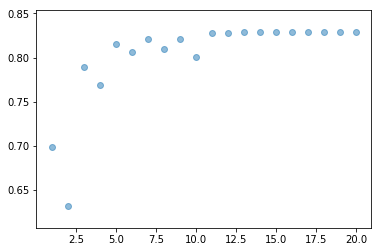

In [61]:
plt.scatter(range(1,21), Klist, alpha = 0.5)

In [68]:
# KNN K = 5
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_mc, np.ravel(Y_categorize), cv=10)
print("KNN K=7\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(knn, X_mc, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

KNN K=7
Accuracy: 0.81 (+/- 0.01)
Accuracy: 0.81483508926 
Precision: 0.827939316524 
Recall: 0.980218851258 
f1: 0.897638667799


In [69]:
# logistic regression
logreg = LogisticRegression()
scores = cross_val_score(logreg, X_mc, np.ravel(Y_categorize), cv=10)
print("Logistic Regression\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(logreg, X_mc, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Logistic Regression
Accuracy: 0.83 (+/- 0.00)
Accuracy: 0.828527182934 
Precision: 0.828527182934 
Recall: 1.0 
f1: 0.906223490207


In [70]:
# LDA
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, X_mc, np.ravel(Y_categorize), cv=10)
print("LDA\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(lda, X_mc, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

LDA
Accuracy: 0.83 (+/- 0.00)
Accuracy: 0.828527182934 
Precision: 0.828527182934 
Recall: 1.0 
f1: 0.906223490207


In [71]:
# QDA
qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(qda, X_subset, np.ravel(Y_categorize), cv=10)
print("QDA\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(qda, X_mc, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

QDA
Accuracy: 0.28 (+/- 0.03)
Accuracy: 0.268150468614 
Precision: 0.881265787588 
Recall: 0.134588661893 
f1: 0.233005122566


In [73]:
# Decision Trees
dtree = tree.DecisionTreeClassifier()
scores = cross_val_score(dtree, X_mc, Y_categorize, cv=10)
print("Decision Tree\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(dtree, X_mc, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Decision Tree
Accuracy: 0.81 (+/- 0.01)
Accuracy: 0.806640923799 
Precision: 0.827819549529 
Recall: 0.967948343951 
f1: 0.892414178271


In [12]:
# Random Forest
forest = RandomForestClassifier(min_samples_leaf=10, n_jobs=4, class_weight="balanced")
scores = cross_val_score(forest, X_mc, np.ravel(Y_categorize), cv=10)
print("Random Forest\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(forest, X_mc, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

NameError: name 'X_mc' is not defined

In [75]:
# SVM
svmModel = svm.SVC()
scores = cross_val_score(svmModel, X_mc, np.ravel(Y_categorize), cv=10)
print("SVM\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(svmModel, X_mc, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

SVM
Accuracy: 0.83 (+/- 0.00)
Accuracy: 0.828319713831 
Precision: 0.828491527695 
Recall: 0.999749530271 
f1: 0.906099289111


In [78]:
# Random Forest feature importance
model = forest.fit(X, np.ravel(Y_categorize))

In [81]:
model.feature_importances_

array([ 0.0295074 ,  0.18699095,  0.18450372,  0.09628375,  0.13941174,
        0.06025604,  0.03088618,  0.06780123,  0.03413455,  0.00692681,
        0.00211333,  0.02957305,  0.00153587,  0.01094869,  0.03156839,
        0.0031633 ,  0.00579068,  0.0009316 ,  0.00456863,  0.00180336,
        0.00145329,  0.00039264,  0.00461013,  0.00230924,  0.01519324,
        0.00261735,  0.00937609,  0.        ,  0.00494623,  0.00256138,
        0.00043404,  0.        ,  0.00232076,  0.0205739 ,  0.00267048,
        0.00137872,  0.        ,  0.00046322])

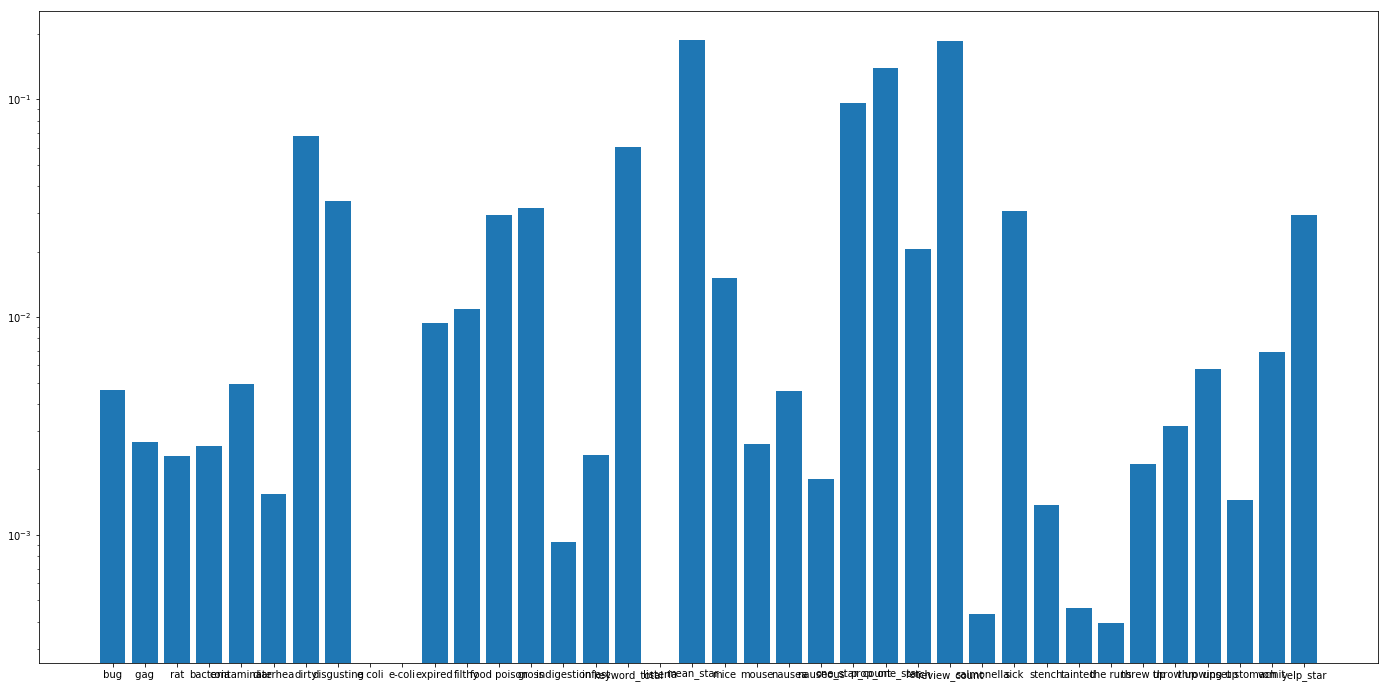

In [98]:
plt.figure(figsize=(24,12))
plt.yscale('log')
plt.bar(list(X.columns.values), model.feature_importances_)
plt.show()

In [104]:
importance = dict(zip(X.columns.values, model.feature_importances_))

In [119]:
sorted(importance, key=importance.get, reverse=True)

tabl = PrettyTable()
tabl.add_column("Feature", sorted(importance, key=importance.get, reverse=True))
tabl.add_column("Importance", sorted(importance.values(), reverse=True))
print(tabl)

+----------------+-------------------+
|    Feature     |     Importance    |
+----------------+-------------------+
|   mean_star    |   0.186990952267  |
|  review_count  |   0.184503720735  |
| prop_one_star  |   0.139411739692  |
| one_star_count |  0.0962837542973  |
|     dirty      |  0.0678012322568  |
| keyword_total  |  0.0602560360584  |
|   disgusting   |  0.0341345474531  |
|     gross      |  0.0315683930934  |
|      sick      |  0.0308861827583  |
|  food poison   |  0.0295730546742  |
|   yelp_star    |  0.0295074025448  |
|     retch      |  0.0205738976272  |
|      mice      |  0.0151932363507  |
|     filthy     |  0.0109486936777  |
|    expired     |  0.00937609094754 |
|     vomit      |  0.00692681004912 |
|  throwing up   |  0.00579068174561 |
|  contaminate   |  0.00494622861632 |
|      bug       |  0.00461012937213 |
|     nausea     |  0.00456863094473 |
|    throw up    |  0.0031632996892  |
|      gag       |  0.00267048478665 |
|     mouse      |  0.002

In [17]:
##########################
## Tuning Random Forest ##
##########################

10
20
30
40
50
60
70
80
90
100
[0.732158576732163, 0.6947035342389902, 0.6646245050931953, 0.6503079645728851, 0.6403532193983039, 0.6169100798961529, 0.6133768627397662, 0.6155591663550598, 0.6051864654727888, 0.5950204823319083, 0.5929466561889073, 0.5847536727469239, 0.5843366905385532, 0.5758304649093848, 0.5727188516552467, 0.5661828303609177, 0.5581971028142312, 0.5577736611962054, 0.5609920181316229, 0.5546736736738748, 0.5431486061166388, 0.5482304107568805, 0.5441875582790765, 0.5314308995537799, 0.5320404081361012, 0.5465700142920551, 0.5400389333867714, 0.5329924154568697, 0.5402467281057368, 0.5256158548021691, 0.5211598987087409, 0.5299770145435954, 0.5125509036554035, 0.5205325414110045, 0.5252063052795186, 0.5118201393199088, 0.5208392294171869, 0.5063306009938957, 0.5136940331937259, 0.5019665446426963, 0.5048776687204031, 0.511820456675552, 0.507870370612229, 0.49118600414060365, 0.4967839155676373, 0.48297817497353723, 0.495842121115371, 0.4971988406014919, 0.50560253

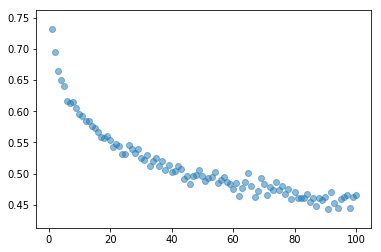

In [106]:
# min_samples_leaf
flist = []
for f in range(1,101):
    forest = RandomForestClassifier(min_samples_leaf=f, n_estimators=15, n_jobs=-1, class_weight="balanced")
    fscores = cross_val_score(forest, X, np.ravel(Y_categorize), cv=10)
    flist.append(fscores.mean())
    if (f%10 == 0): 
        print(f)
plt.scatter(range(1,101), flist, alpha = 0.5)
print(flist)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
[0.6702331677658915, 0.6208483379594922, 0.703315545677903, 0.6883810054420633, 0.7147279543259704, 0.706120789397772, 0.7289340949332961, 0.7213666400034346, 0.7246853891538133, 0.7298724392173526, 0.7283196519897887, 0.7298730857611041, 0.7353676788938672, 0.7316393661558324, 0.7386877204619867, 0.7316387227376377, 0.7365157530630625, 0.7301869787338677, 0.7378625772595783, 0.7331930184928703, 0.7341272770044147, 0.7370371144689861, 0.7337125533457199, 0.7325753475189409, 0.7346451922607016, 0.7371375140513313, 0.7381706604919953, 0.7366180878115809, 0.7358920540063176, 0.735889361450753, 0.7386896556281599, 0.7387971555825603, 0.7368250185373426, 0.7407680031123403, 0.737446994072761, 0.7377578753482847, 0.7376531725439748, 0.7342327345190669, 0.7360972618805149, 0.7350593815608087, 0.7379657748850303, 0.7355813890639759, 0.7381730285477864, 0.7372393090831652, 0.7387943597719941, 0.7362021803482446, 0.7387959744569674, 0.7

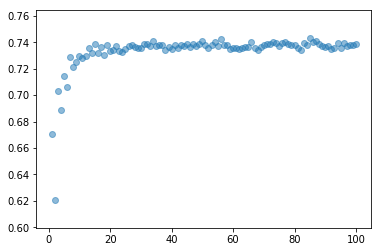

In [103]:
# n_estimators
flist = []
for f in range(1,101):
    forest = RandomForestClassifier(min_samples_leaf=1, n_jobs=-1, n_estimators=f, class_weight="balanced")
    fscores = cross_val_score(forest, X, np.ravel(Y_categorize), cv=10)
    flist.append(fscores.mean())
    if (f%5 == 0): 
        print(f)
plt.scatter(range(1,101), flist, alpha = 0.5)
print(flist)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
[0.7356874888805526, 0.7337091107681483, 0.7310123351439014, 0.7231343212057486, 0.7232330006155785, 0.7135859082395906, 0.7141087752708805, 0.7103742234749454, 0.7152529757589181, 0.7073653867891062, 0.7041500491415669, 0.7063270720170037, 0.7042506619315374, 0.7037334917856685, 0.7007272365864999, 0.6948155577671102, 0.6980283139279791, 0.6908699859008365, 0.6934633482362116, 0.6922165988990139, 0.6866148289720988, 0.6957476598677099, 0.692945215307218, 0.6820499710004142, 0.6796658012892878, 0.6801852223941948, 0.6836083549839536, 0.6785286976012401, 0.6758347251549435, 0.6840261958274307, 0.6765546220410382, 0.6729257447626998, 0.6777991157308627, 0.677697748900312, 0.6667032890390585, 0.6722016490259124, 0.6733434803418885, 0.6669069937436846, 0.6609950925632533, 0.6627576112387343, 0.660478466152642, 0.6723012941211691, 0.6674267377855864, 0.6703318458361969, 0.6638985828033339, 0.6633790459411977, 0.6631785752948534, 0.

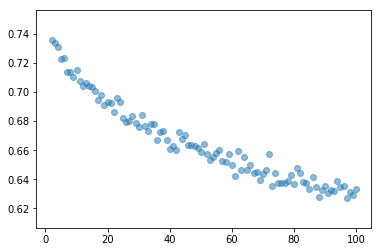

In [108]:
# min_samples_split
flist = []
for f in range(2,101):
    forest = RandomForestClassifier(min_samples_leaf=1, n_jobs=-1, min_samples_split = f, n_estimators=15, class_weight="balanced")
    fscores = cross_val_score(forest, X, np.ravel(Y_categorize), cv=10)
    flist.append(fscores.mean())
    if (f%5 == 0): 
        print(f)
plt.scatter(range(2,101), flist, alpha = 0.5)
print(flist)

In [119]:
flist.index(max(flist))

35

In [105]:
# Random Forest
forest = RandomForestClassifier(min_samples_leaf=1, n_jobs=-1, n_estimators=15, class_weight="balanced")
scores = cross_val_score(forest, X, np.ravel(Y_categorize), cv=10)
print("Random Forest\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(forest, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Random Forest
Accuracy: 0.74 (+/- 0.03)
Accuracy: 0.7335083118267118 
Precision: 0.8291167346546864 
Recall: 0.8543903563665107 
f1: 0.8414962527132916


49

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
[0.2952208702626242, 0.3325782146591785, 0.331110214969323, 0.3485546206345376, 0.3683648885083747, 0.41016688642679844, 0.4295593179222397, 0.42830491956613964, 0.41989694157345314, 0.4536271277479143, 0.460791363858816, 0.45746378746624483, 0.46005661231747563, 0.46690847068090413, 0.456638754886222, 0.4551874417627837, 0.45726805449426144, 0.46141700210030717, 0.4596530857427972, 0.4658768350004495, 0.46836753987356544, 0.47023250213391804, 0.46805332441031516, 0.4698162726266034, 0.4663906667167648, 0.4659757294039369, 0.4670104918690984, 0.46950291669147576, 0.4721980753982088, 0.46690621793583365, 0.4723034258625403, 0.47188934830108903, 0.4735474868860008, 0.4729274474097719, 0.4732387555470541, 0.4794602424597114, 0.47759624945685075, 0.47800731241875927, 0.47862993695372386, 0.4767608853487939]


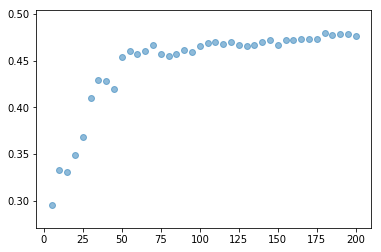

In [118]:
# Boosting paramter: n_estimators
flist = []
for f in range(5,201,5):
    boostedtrees =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, class_weight="balanced"), n_estimators=f)
    fscores = cross_val_score(boostedtrees, X, np.ravel(Y_categorize), cv=10)
    flist.append(fscores.mean())
    if (f%5 == 0): 
        print(f)
plt.scatter(range(5,201,5), flist, alpha = 0.5)
print(flist)

In [121]:
# Boosted Decision Trees - adaboost
boostedtrees =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, class_weight="balanced"), n_estimators=35)
scores = cross_val_score(boostedtrees, X, np.ravel(Y_categorize), cv=10)
print("Boosted Decision Trees\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(boostedtrees, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Boosted Decision Trees
Accuracy: 0.43 (+/- 0.10)
Accuracy: 0.4295593179222397 
Precision: 0.8445367610034242 
Recall: 0.38161376532695945 
f1: 0.521765530917283
